In [44]:
from tensorflow import keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from keras.engine.training import optimizer
import cv2

In [45]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images / 255
test_images = test_images / 255

In [46]:
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


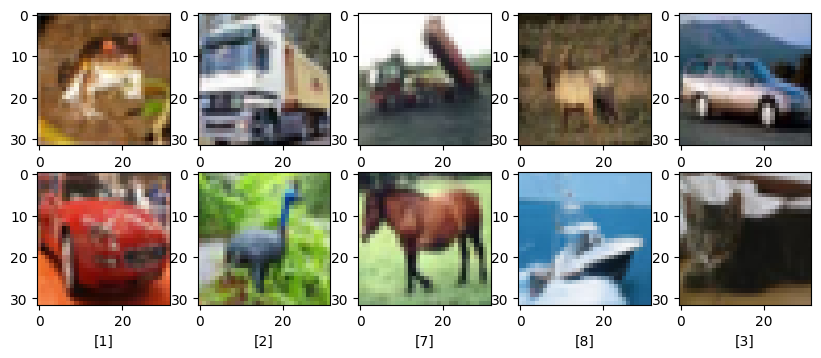

In [47]:
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.imshow(train_images[i])
  plt.xlabel(train_labels[i])

In [48]:
def def_model():
  model = keras.Sequential()

  model.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(32,32,3)))
  model.add(MaxPooling2D(pool_size=[2,2], strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=[2,2], strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=[2,2], strides=2))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.33))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

In [49]:
def plot_history(history, test_images, test_labels, model):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='lower left')
  plt.show()

  plt.plot(history.history['acuraccy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()

  test_loss, test_acc = model.evaluate(test_images, test_labels)

  print(test_loss)
  print(test_acc)

In [50]:
model = def_model()

callbacksModel = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=3, min_lr=0.0001),
    keras.callbacks.ModelCheckpoint(
        save_best_only=True,
        filepath='best_model.h5'
    )
]

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                     

Epoch 1/15
1250/1250 [==============================] - 11s 6ms/step - loss: 1.4204 - accuracy: 0.5080 - val_loss: 1.1942 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0056 - accuracy: 0.6470 - val_loss: 1.1319 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 3/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8122 - accuracy: 0.7180 - val_loss: 0.9010 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 4/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6557 - accuracy: 0.7719 - val_loss: 0.9984 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 5/15
1250/1250 [==============================] - 11s 9ms/step - loss: 0.5285 - accuracy: 0.8155 - val_loss: 1.0800 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 6/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4016 - accuracy: 0.8626 - val_loss: 1.1912 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 7/15
1250/1250 [==============================] -

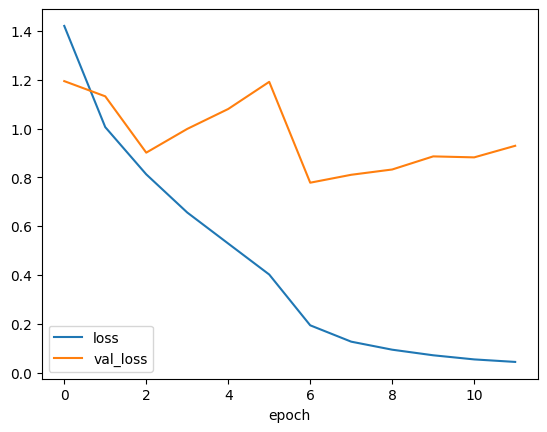

KeyError: ignored

In [51]:
from keras.api._v2.keras import callbacks
history = model.fit(train_images, train_labels, 
                    epochs=15, validation_split=0.2,
                    callbacks = callbacksModel)

plot_history(history, test_images, test_labels, model)